## The imports for this Jupyter notebook and context
pandas for DataFrames, data loading and wrangling
numpy for math utilities
scikit-learn for training a regressor with KFold cross-validation
sentence-transformers for the text to vector embeddings to become input features for scikit-learn
matplotlib for plotting distributions

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import os
import glob
from pathlib import Path
print("All imported")

All imported


## Workflow for data and processing

- pandas (load/clean) 
- sentence-transformers (embed text)
- numpy (store as arrays)
- scikit-learn (train/eval models) 
- matplotlib (visualize results).

## Import and clean data

In [43]:
# Define the dataset directory
dataset_dir = "data/datasets/storypoint/IEEE TSE2018/dataset"
# dataset_dir = "dummy_data" # This is a test csv to ensure cleaning of NULL values.
# Function to clean individual dataframes
def clean_dataframe(df, filename):
    """Clean a single dataframe with common preprocessing steps."""
    print(f"Cleaning {filename}:")
    print(f"  Original shape: {df.shape}")
    
    # Replace various NULL representations with actual NaN
    df = df.replace(['NULL', 'null', 'Null', ''], pd.NA)
    
    # Remove rows where ANY column has NaN/NULL values
    df = df.dropna(how='any')
    
    # Remove completely empty rows and columns
    df = df.dropna(how='all').dropna(axis=1, how='all')
    
    # Strip whitespace from string columns
    string_columns = df.select_dtypes(include=['object']).columns
    for col in string_columns:
        df[col] = df[col].astype(str).str.strip()
        # Remove rows with 'nan' strings that might have been created
        df = df[df[col] != 'nan']
        df = df[df[col] != 'None']
    
    # Convert numeric columns (story points, etc.)
    numeric_keywords = ['storypoint']
    for col in df.columns:
        if any(keyword in col.lower() for keyword in numeric_keywords):
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Remove rows where numeric conversion failed
            df = df.dropna(subset=[col])
    
    print(f"  Cleaned shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    print(f"  Data types: {df.dtypes.to_dict()}")
    print()
    
    return df

# Import all CSV files
csv_files = glob.glob(os.path.join(dataset_dir, "*.csv"))
dataframes = {}

print(f"Found {len(csv_files)} CSV files in {dataset_dir}")
print(f"These are the files: {csv_files}")
print("=" * 50)

for csv_file in csv_files:
    filename = Path(csv_file).name
    try:
        # Try different encodings
        df = None
        for encoding in ['utf-8', 'latin-1', 'cp1252']:
            try:
                # Read CSV keeping NULL as strings initially so we can handle them properly
                df = pd.read_csv(csv_file, encoding=encoding, keep_default_na=False)
                print(f"Successfully loaded {filename} with {encoding} encoding")
                break
            except UnicodeDecodeError:
                print(f"Failed to load {filename} with {encoding} encoding")
                continue
        
        if df is None:
            # If all encodings fail, use utf-8 with error handling
            df = pd.read_csv(csv_file, encoding='utf-8', errors='ignore', keep_default_na=False)
            print(f"Loaded {filename} with utf-8 encoding and error handling")
        
        # Clean the dataframe
        df_cleaned = clean_dataframe(df, filename)
        
        if len(df_cleaned) > 0:  # Only store if we have data left after cleaning
            # Store with filename as key (without .csv extension)
            key = filename.replace('.csv', '')
            dataframes[key] = df_cleaned
            
            # Display first few rows
            print(f"Sample data from {filename}:")
            print(df_cleaned.head())
        else:
            print(f"No data remaining after cleaning {filename}")
        
        print("=" * 50)
        
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")
        print("=" * 50)

# Summary
print(f"\nSuccessfully loaded {len(dataframes)} datasets:")
for name, df in dataframes.items():
    print(f"  {name}: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"    No missing values (all NULL entries completely removed)")

Found 16 CSV files in data/datasets/storypoint/IEEE TSE2018/dataset
These are the files: ['data/datasets/storypoint/IEEE TSE2018/dataset/usergrid.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/bamboo.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/mule.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/jirasoftware.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/talenddataquality.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/duracloud.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/moodle.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/appceleratorstudio.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/talendesb.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/mesos.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/springxd.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/aptanastudio.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/mulestudio.csv', 'data/datasets/storypoint/IEEE TSE2018/dataset/datamanagement.csv', 'data/datasets/s

## Embed text

In [44]:

# Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

for name, df in dataframes.items():
    # Calculate the embeddings and add as a new column to the dataframe for the story
    sentences = df['description'].tolist()
    embeddings = model.encode(sentences)

    print(f"Embeddings Shape for {name}: {embeddings.shape}")
    
    # Store as numpy arrays for scikit-learn
    df['embeddings'] = [np.array(emb) for emb in embeddings]

for name, df in dataframes.items():
    print(f"{name}: {df.shape[0]} rows, embedding dimension: {df['embeddings'].iloc[0].shape}")
    # print(f"Type of stored embedding: {type(df['embeddings'].iloc[0])}")
    print(f"Dataframe: {df}")

Embeddings Shape for usergrid: (333, 384)
Embeddings Shape for bamboo: (374, 384)
Embeddings Shape for mule: (889, 384)
Embeddings Shape for jirasoftware: (286, 384)
Embeddings Shape for talenddataquality: (1136, 384)
Embeddings Shape for duracloud: (613, 384)
Embeddings Shape for moodle: (1166, 384)
Embeddings Shape for appceleratorstudio: (2876, 384)
Embeddings Shape for talendesb: (775, 384)
Embeddings Shape for mesos: (1562, 384)
Embeddings Shape for springxd: (3056, 384)
Embeddings Shape for aptanastudio: (771, 384)
Embeddings Shape for mulestudio: (732, 384)
Embeddings Shape for datamanagement: (4030, 384)
Embeddings Shape for titanium: (2122, 384)
Embeddings Shape for clover: (361, 384)
usergrid: 333 rows, embedding dimension: (384,)
Dataframe:           issuekey                                              title  \
0      USERGRID-16  Asset data does not correctly obey contextual ...   
1      USERGRID-17              Expose refresh token at the REST tier   
2      USERGRID-19 

## Train model

In [63]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Combine all dataframes into one dataset
print("Combining all datasets:")
all_embeddings = []
all_storypoints = []
dataset_info = []

for name, df in dataframes.items():
    print(f"  {name}: {df.shape[0]} rows")
    
    # Stack embeddings and storypoints from this dataset
    embeddings = np.vstack(df['embeddings'].values)
    storypoints = df['storypoint'].astype(float).values
    
    all_embeddings.append(embeddings)
    all_storypoints.append(storypoints)
    
    # Keep track of which dataset each sample came from (for analysis)
    dataset_info.extend([name] * len(storypoints))

# Combine all datasets
X = np.vstack(all_embeddings)
y = np.concatenate(all_storypoints)
dataset_labels = np.array(dataset_info)

print(f"\nCombined dataset:")
print(f"  Total samples: {len(X)}")
print(f"  Feature dimensions: {X.shape[1]}")
print(f"  Story point range: {y.min():.1f} - {y.max():.1f}")
print(f"  Datasets included: {list(dataframes.keys())}")

# Sanity checks
assert X.ndim == 2, "Embeddings didn't stack to 2D; check shapes."
assert len(X) == len(y), "Feature/target length mismatch."
assert len(X) == len(dataset_labels), "Dataset labels length mismatch."

# Train/validation split (stratified by dataset if possible)
X_tr, X_te, y_tr, y_te, labels_tr, labels_te = train_test_split(
    X, y, dataset_labels, test_size=0.2, random_state=42, stratify=dataset_labels
)

print(f"\nTrain/Test split:")
print(f"  Training: {len(X_tr)} samples")
print(f"  Testing: {len(X_te)} samples")

# Show distribution across datasets
print(f"\nDataset distribution in training set:")
train_counts = pd.Series(labels_tr).value_counts()
for dataset, count in train_counts.items():
    print(f"  {dataset}: {count} samples ({100*count/len(labels_tr):.1f}%)")

print(f"\nDataset distribution in test set:")
test_counts = pd.Series(labels_te).value_counts()
for dataset, count in test_counts.items():
    print(f"  {dataset}: {count} samples ({100*count/len(labels_te):.1f}%)")

# Define models
models = {
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42)),
    "ElasticNet": make_pipeline(StandardScaler(), ElasticNet(alpha=0.05, l1_ratio=0.2, random_state=42)),
    "SVR(RBF)": make_pipeline(StandardScaler(), SVR(kernel="rbf", C=2.0, epsilon=0.2)),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    "HistGBR": HistGradientBoostingRegressor(loss="squared_error", max_depth=None, random_state=42)
}

# Cross-validate each model with MAE (lower is better)
print(f"\nCross-validating models...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
for name, model in models.items():
    print(f"  Training {name}...")
    scores = cross_val_score(model, X_tr, y_tr, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
    cv_results[name] = -scores.mean()

# Pick the best by CV MAE and fit it on the full training set
best_name = min(cv_results, key=cv_results.get)
best_model = models[best_name]
best_model.fit(X_tr, y_tr)

# Evaluate on the held-out test set
pred = best_model.predict(X_te)
mae = mean_absolute_error(y_te, pred)
rmse = root_mean_squared_error(y_te, pred)

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print("CV MAE per model:", {k: f"{v:.3f}" for k, v in cv_results.items()})
print(f"Best model: {best_name}")
print(f"Test MAE:  {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")

# Round predictions for discrete story points
pred_rounded = np.rint(pred).astype(int)
print(f"Rounded Test MAE: {mean_absolute_error(y_te, pred_rounded):.3f}")

# Performance by dataset
print(f"\nPerformance by dataset:")
for dataset in np.unique(labels_te):
    mask = labels_te == dataset
    if np.sum(mask) > 0:
        dataset_mae = mean_absolute_error(y_te[mask], pred[mask])
        dataset_mae_rounded = mean_absolute_error(y_te[mask], pred_rounded[mask])
        print(f"  {dataset}: MAE={dataset_mae:.3f}, MAE(rounded)={dataset_mae_rounded:.3f} ({np.sum(mask)} samples)")

Combining all datasets:
  usergrid: 333 rows
  bamboo: 374 rows
  mule: 889 rows
  jirasoftware: 286 rows
  talenddataquality: 1136 rows
  duracloud: 613 rows
  moodle: 1166 rows
  appceleratorstudio: 2876 rows
  talendesb: 775 rows
  mesos: 1562 rows
  springxd: 3056 rows
  aptanastudio: 771 rows
  mulestudio: 732 rows
  datamanagement: 4030 rows
  titanium: 2122 rows
  clover: 361 rows

Combined dataset:
  Total samples: 21082
  Feature dimensions: 384
  Story point range: 1.0 - 100.0
  Datasets included: ['usergrid', 'bamboo', 'mule', 'jirasoftware', 'talenddataquality', 'duracloud', 'moodle', 'appceleratorstudio', 'talendesb', 'mesos', 'springxd', 'aptanastudio', 'mulestudio', 'datamanagement', 'titanium', 'clover']

Train/Test split:
  Training: 16865 samples
  Testing: 4217 samples

Dataset distribution in training set:
  datamanagement: 3224 samples (19.1%)
  springxd: 2445 samples (14.5%)
  appceleratorstudio: 2301 samples (13.6%)
  titanium: 1697 samples (10.1%)
  mesos: 1249 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Training ElasticNet...
  Training SVR(RBF)...
  Training RandomForest...


KeyboardInterrupt: 

## Visualize Data

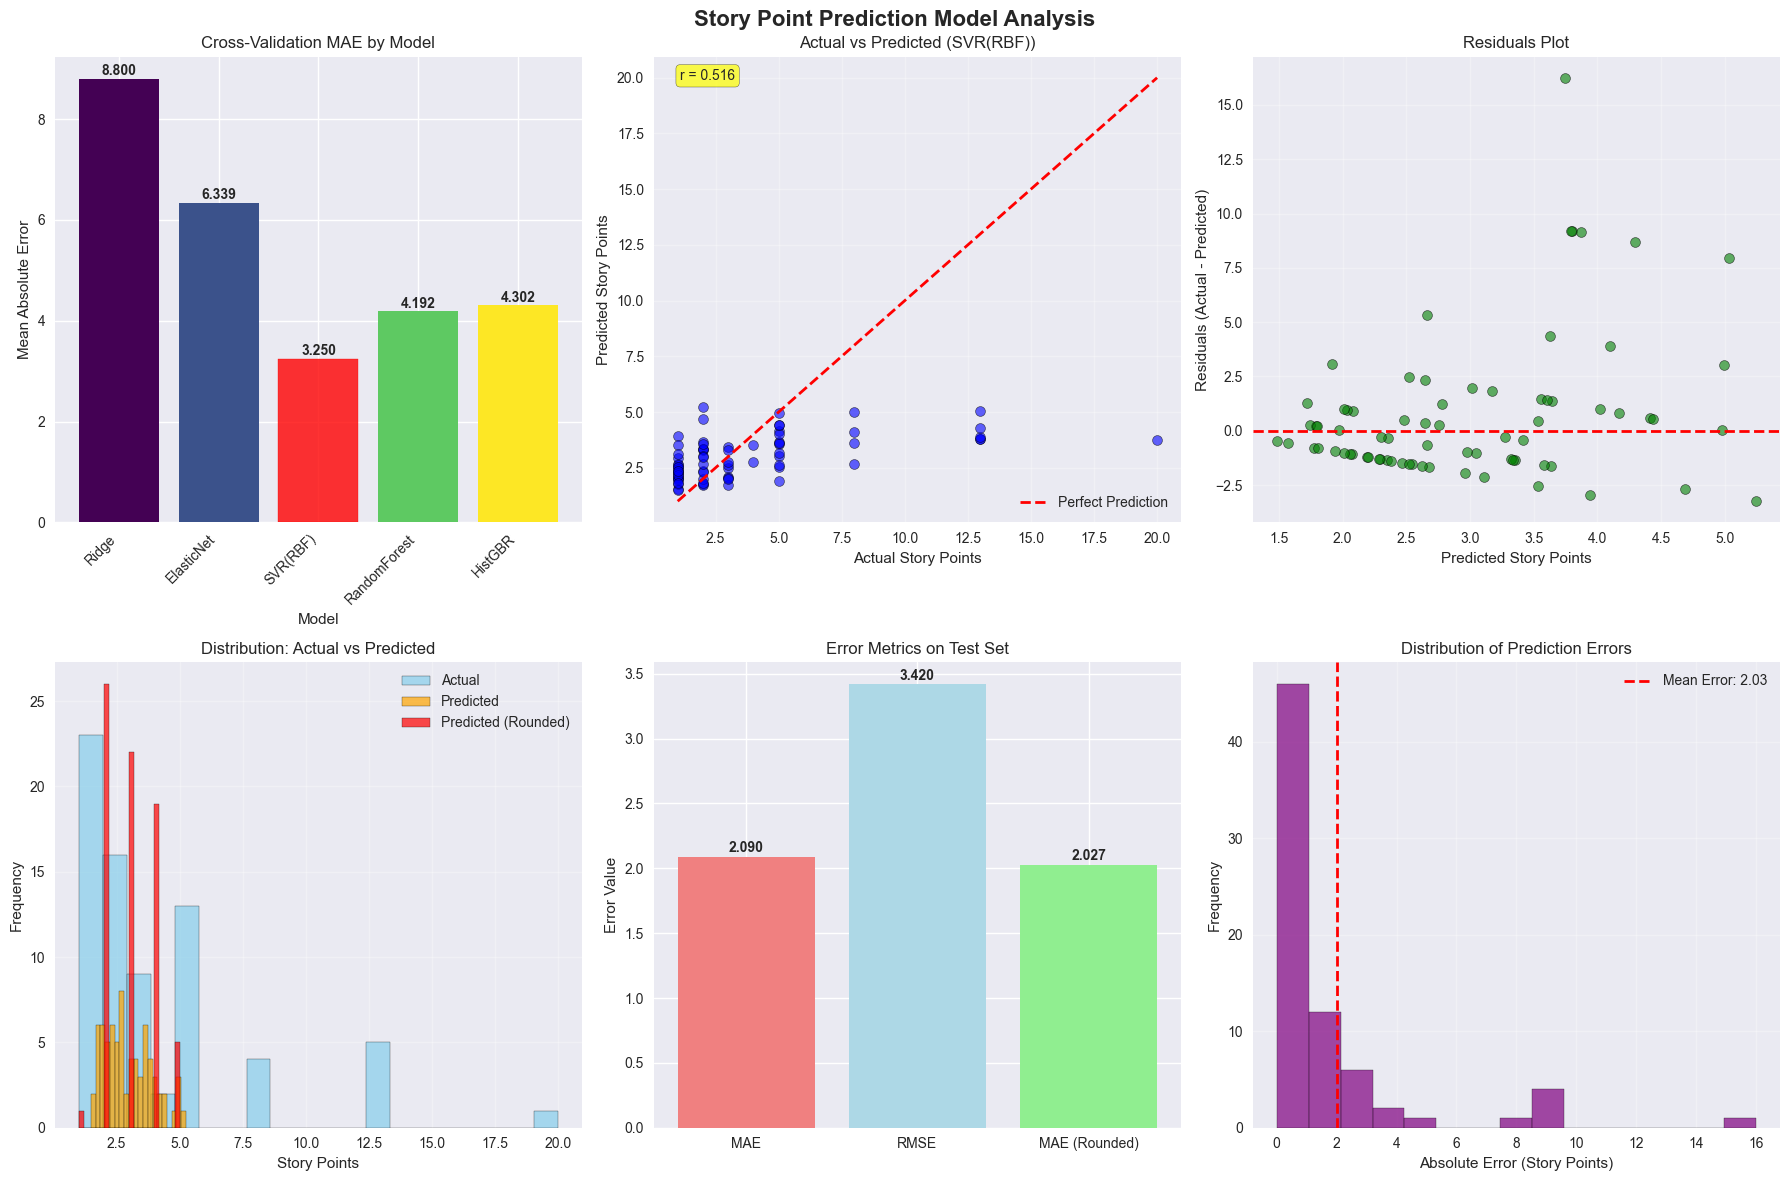


DETAILED ANALYSIS


/var/folders/91/n91s8z9s3cx3frdx3n4wm0jw0000gn/T/ipykernel_59304/805970511.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_data, labels=labels)


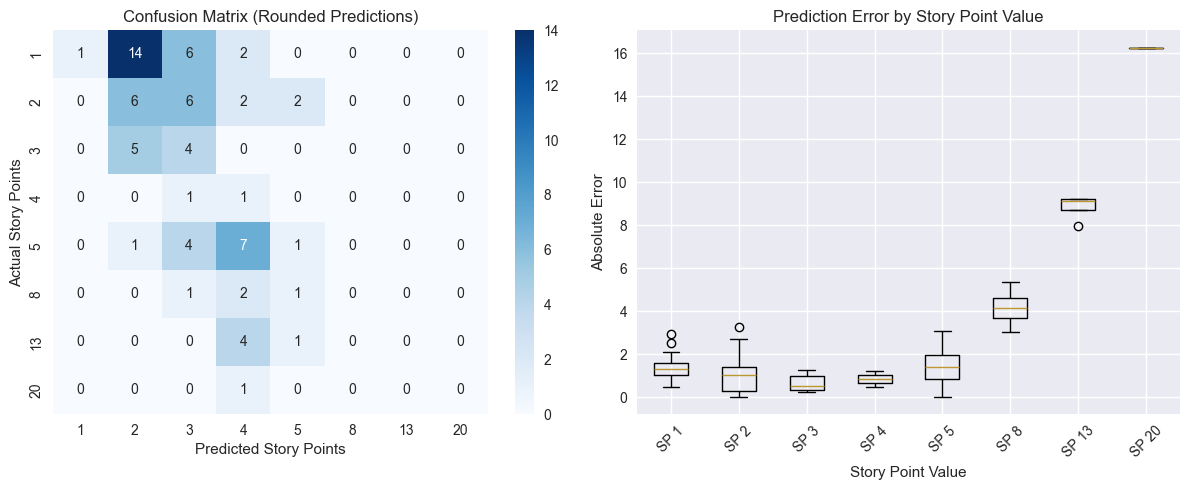


Model Performance Summary:
Best Model: SVR(RBF)
CV MAE: 3.250
Test MAE: 2.090
Test RMSE: 3.420
Test MAE (Rounded): 2.027
Correlation: 0.516
Perfect predictions: 13 / 73 (17.8%)


In [ ]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Story Point Prediction Model Analysis', fontsize=16, fontweight='bold')

# 1. Cross-validation MAE comparison
ax1 = axes[0, 0]
model_names = list(cv_results.keys())
mae_scores = list(cv_results.values())
bars = ax1.bar(model_names, mae_scores, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
ax1.set_title('Cross-Validation MAE by Model')
ax1.set_ylabel('Mean Absolute Error')
ax1.set_xlabel('Model')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, score in zip(bars, mae_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight best model
best_idx = model_names.index(best_name)
bars[best_idx].set_color('red')
bars[best_idx].set_alpha(0.8)

# 2. Actual vs Predicted scatter plot
ax2 = axes[0, 1]
scatter = ax2.scatter(y_te, pred, alpha=0.6, s=50, color='blue', edgecolors='black', linewidth=0.5)
ax2.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Story Points')
ax2.set_ylabel('Predicted Story Points')
ax2.set_title(f'Actual vs Predicted ({best_name})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(y_te, pred)[0, 1]
ax2.text(0.05, 0.95, f'r = {correlation:.3f}', transform=ax2.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# 3. Residuals plot
ax3 = axes[0, 2]
residuals = y_te - pred
ax3.scatter(pred, residuals, alpha=0.6, s=50, color='green', edgecolors='black', linewidth=0.5)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Story Points')
ax3.set_ylabel('Residuals (Actual - Predicted)')
ax3.set_title('Residuals Plot')
ax3.grid(True, alpha=0.3)

# 4. Distribution of actual vs predicted story points
ax4 = axes[1, 0]
ax4.hist(y_te, alpha=0.7, label='Actual', bins=20, color='skyblue', edgecolor='black')
ax4.hist(pred, alpha=0.7, label='Predicted', bins=20, color='orange', edgecolor='black')
ax4.hist(pred_rounded, alpha=0.7, label='Predicted (Rounded)', bins=20, color='red', edgecolor='black')
ax4.set_xlabel('Story Points')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution: Actual vs Predicted')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Error metrics comparison
ax5 = axes[1, 1]
metrics = ['MAE', 'RMSE', 'MAE (Rounded)']
values = [mae, rmse, mean_absolute_error(y_te, pred_rounded)]
bars = ax5.bar(metrics, values, color=['lightcoral', 'lightblue', 'lightgreen'])
ax5.set_title('Error Metrics on Test Set')
ax5.set_ylabel('Error Value')

# Add value labels
for bar, value in zip(bars, values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. Prediction error distribution
ax6 = axes[1, 2]
errors = np.abs(y_te - pred_rounded)
ax6.hist(errors, bins=15, color='purple', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Absolute Error (Story Points)')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Prediction Errors')
ax6.grid(True, alpha=0.3)

# Add statistics
mean_error = np.mean(errors)
ax6.axvline(mean_error, color='red', linestyle='--', linewidth=2, 
            label=f'Mean Error: {mean_error:.2f}')
ax6.legend()

plt.tight_layout()
plt.show()

# Additional detailed plots
print("\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

# Confusion matrix-style for rounded predictions
plt.figure(figsize=(12, 5))

# Left subplot: Confusion matrix heatmap
plt.subplot(1, 2, 1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te.astype(int), pred_rounded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_te.astype(int)), 
            yticklabels=np.unique(y_te.astype(int)))
plt.title('Confusion Matrix (Rounded Predictions)')
plt.xlabel('Predicted Story Points')
plt.ylabel('Actual Story Points')

# Right subplot: Box plot of errors by story point value
plt.subplot(1, 2, 2)
error_data = []
labels = []
for sp in sorted(np.unique(y_te.astype(int))):
    mask = y_te.astype(int) == sp
    if np.sum(mask) > 0:
        error_data.append(np.abs(y_te[mask] - pred[mask]))
        labels.append(f'SP {sp}')

plt.boxplot(error_data, labels=labels)
plt.title('Prediction Error by Story Point Value')
plt.xlabel('Story Point Value')
plt.ylabel('Absolute Error')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nModel Performance Summary:")
print(f"Best Model: {best_name}")
print(f"CV MAE: {cv_results[best_name]:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE (Rounded): {mean_absolute_error(y_te, pred_rounded):.3f}")
print(f"Correlation: {correlation:.3f}")
print(f"Perfect predictions: {np.sum(pred_rounded == y_te.astype(int))} / {len(y_te)} ({100*np.sum(pred_rounded == y_te.astype(int))/len(y_te):.1f}%)")

In [ ]:
def predict_story_points(text_description, model=best_model, sentence_transformer=model):
    """
    Predict story points for a given text description.
    
    Args:
        text_description (str): The story description text
        model: The trained regression model
        sentence_transformer: The sentence transformer model for embeddings
    
    Returns:
        dict: Prediction results
    """
    # 1. Generate embedding for the input text
    embedding = sentence_transformer.encode([text_description])
    
    # 2. Make prediction
    prediction = model.predict(embedding)[0]
    prediction_rounded = int(np.round(prediction))
    
    return {
        'raw_prediction': prediction,
        'rounded_prediction': prediction_rounded,
        'text': text_description
    }

# Example usage:
user_inputs = [
    "Create a login page with email and password validation",
    "Implement user authentication system with JWT tokens",
    "Fix bug in payment processing module",
    "Add search functionality to the product catalog",
    "Refactor database connection pooling for better performance"
]

print("Story Point Predictions:")
print("=" * 60)

for text in user_inputs:
    result = predict_story_points(text)
    print(f"Text: {result['text'][:50]}...")
    print(f"Raw Prediction: {result['raw_prediction']:.2f}")
    print(f"Rounded: {result['rounded_prediction']} story points")
    print("-" * 40)

# Interactive prediction function
def interactive_prediction():
    """Interactive function to get user input and predict story points."""
    while True:
        user_text = input("\nEnter a story description (or 'quit' to exit): ")
        
        if user_text.lower() in ['quit', 'exit', 'q']:
            break
            
        if user_text.strip():
            result = predict_story_points(user_text)
            print(f"\nPredicted Story Points: {result['rounded_prediction']}")
            print(f"Raw Score: {result['raw_prediction']:.2f}")
        else:
            print("Please enter a valid description.")

# Uncomment to run interactive mode
# interactive_prediction()